In [ ]:
from pathlib import Path
import zipfile
import requests
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import optim
from torch.nn import functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import PIL
from torch import nn
from sklearn.model_selection import train_test_split

In [ ]:
import requests
from pathlib import Path

# Download helper fun from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_function allredy exist and skip download")
else:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import accuracy_fn

In [ ]:

def dowload_and_unzip(url: str, extend_path: str, name_file: str = None):
    """
    Funkcja pobiera i wypakowuje plik z podanego URL do określonego folderu.

    @param url: URL, z którego pobieramy plik
    @param extend_path: ścieżka, do której wypakowujemy plik
    @param name_file: opcjonalna nazwa pliku, do której zapisujemy pobraną zawartość
    """
    extend_path = Path(extend_path)
    response = requests.get(url)

    if response.status_code == 200:
        try:
            # Jeśli nie podano nazwy pliku, użyj nazwy pliku z adresu URL
            if not name_file:
                name_file = Path(url).name

            # Sprawdzamy, czy pobrana zawartość jest archiwum ZIP
            if zipfile.is_zipfile(response.content):
                # Jeśli tak, tworzymy obiekt ZipFile i wypakowujemy zawartość
                with zipfile.ZipFile(response.content) as zip_ref:
                    zip_ref.extractall(extend_path)
                    print("Plik ZIP został pomyślnie wypakowany.")
            else:
                # Jeśli nie jest to plik ZIP, po prostu zapisujemy go w podanej lokalizacji
                with open(extend_path / name_file, 'wb') as f:
                    f.write(response.content)
                    print("Plik został zapisany na dysku.")
        except Exception as e:
            print("Wystąpił błąd:", e)
    else:
        print("Wystąpił problem podczas pobierania pliku.")

In [ ]:
from google.colab import files
import zipfile
import os

def file_from_pc(target_folder: str = "/content/data"):
    # Pobierz plik z lokalnego komputera na dysk Google Colab
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Sprawdź, czy przesłany plik jest archiwum ZIP
        if filename.endswith('.zip'):
            # Rozpakuj plik ZIP
            with zipfile.ZipFile(filename, 'r') as zip_ref:
                zip_ref.extractall(target_folder)
            print("Plik ZIP został pomyślnie wypakowany.")
        else:
            # Jeśli plik nie jest ZIP, przenieś go do podanej lokalizacji
            os.rename(filename, os.path.join(target_folder, filename))
            print("Przesłany plik został zapisany w podanej lokalizacji:", os.path.join(target_folder, filename))

In [ ]:
file_from_pc()

Saving archive.zip to archive.zip
Plik ZIP został pomyślnie wypakowany.


In [ ]:
import pandas as pd
import PIL
import numpy as np



def read_data(data_path: str):
  data_path = Path(data_path)
  df = pd.read_csv(data_path)
  ## Converting pixels into numpy array
  df['pixels'] = df['pixels'].apply(lambda x:  np.reshape(np.array(x.split(), dtype="float32"), (48, 48)))

  return df

df = read_data(r"/content/data/age_gender.csv")

In [ ]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 13..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175..."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79..."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 20..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 21..."


In [ ]:
def plot_histogram(df: pd.DataFrame,
                   value: str,
                   color: str = 'white',
                   font_color: str = 'black',
                   bar_color="blue") -> None:
    """
    Fun plot histogram of data
    """
    unique_values = df[value].nunique()



    if color:
      plt.figure(figsize=(7, 7), facecolor=color)
    else:
     figure = plt.figure(figsize=(10, 10))

    plt.hist(df[value], bins=unique_values, color=bar_color)
    plt.title(f"{value} histogram", color=font_color)
    plt.xlabel('number', color=font_color)
    plt.ylabel('freq', color=font_color)
    plt.tick_params(axis='x', colors=font_color)  # Zmiana koloru osi x na czerwony
    plt.tick_params(axis='y', colors=font_color)  # Zmiana koloru osi y na niebieski


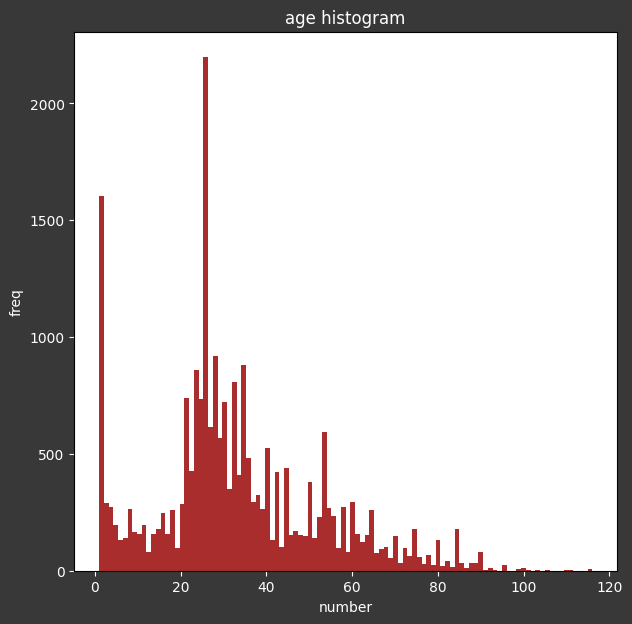

In [ ]:
# age histogram
colors = [56,56,56,255]
colors = [color/255 for color in colors]
plot_histogram(df, "age", color=colors, font_color='white', bar_color=[color/255 for color in [170, 45, 45]])

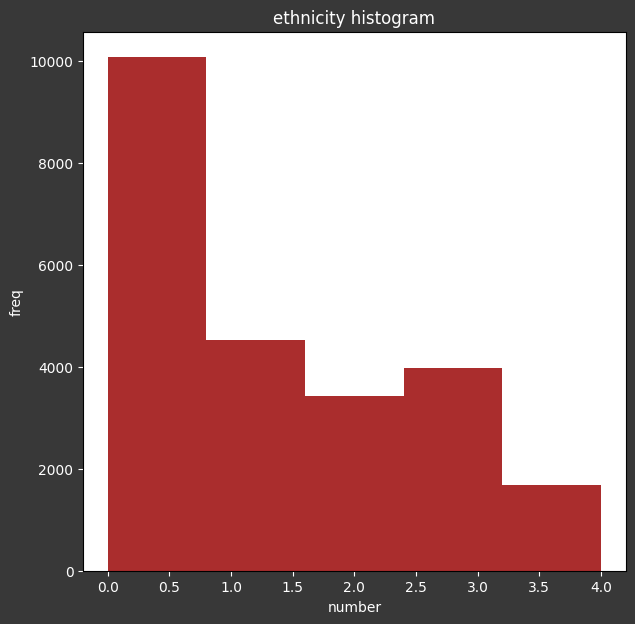

In [ ]:
plot_histogram(df, "ethnicity", color=colors, font_color='white', bar_color=[color/255 for color in [170, 45, 45]])

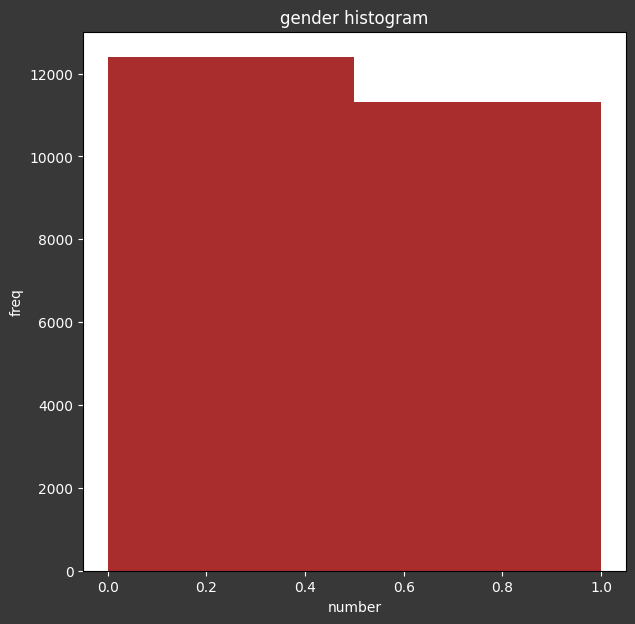

In [ ]:
plot_histogram(df, "gender", color=colors, font_color='white', bar_color=[color/255 for color in [170, 45, 45]])

In [ ]:
eth_values_to_labels = { 0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Hispanic" }
gender_values_to_labels = { 0: "Male", 1: "Female" }

def plot_data(df: pd.DataFrame,
              rows: int,
              cols: int) -> None:
    """
    Plot some data
    @param df: data frame with data
    @param rows: number of rows
    @param cols: number of column
    """
    fig = plt.figure(figsize=(10, 10))

    for i in range(1, rows*cols+1):
        random_int = np.random.randint(0, df.shape[0])
        ax = fig.add_subplot(rows, cols, i)
        age = df['age'][random_int]
        ethnicity = eth_values_to_labels[df["ethnicity"][random_int]]
        gender = gender_values_to_labels[df["gender"][random_int]]
        img = df['pixels'][random_int]

        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f'Gender: {gender}\nAge: {age}\nEthnicity: {ethnicity}')

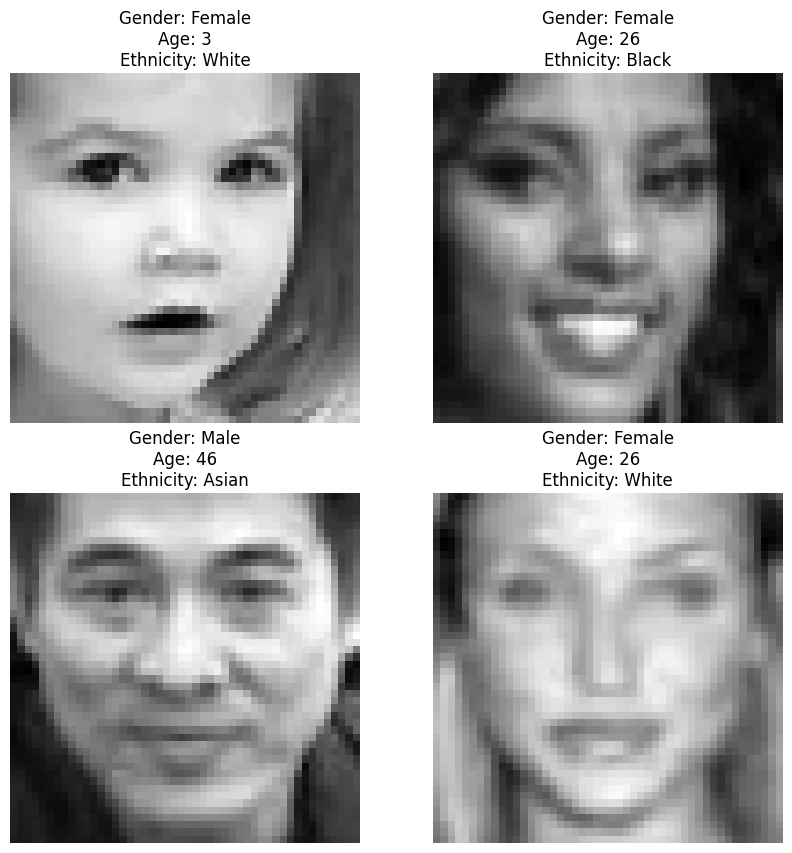

In [ ]:
plot_data(df=df,
          rows=2,
          cols=2)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
import numpy as np

def calculate_mean_std(df):
    # Inicjalizuj listy dla sum pikseli i sum kwadratów pikseli dla każdego kanału
    sum_pixels = [0, 0, 0]
    sum_pixels_squared = [0, 0, 0]

    # Liczba próbek w ramce danych
    num_samples = len(df)

    # Iteruj przez ramkę danych i oblicz sumy pikseli i sumy kwadratów pikseli
    for index, row in df.iterrows():
        # Wczytaj obraz i przekształć go do postaci numpy array
        im = np.array(row['pixels'])
        # Dodaj piksele do sum
        sum_pixels[0] += np.sum(im[:, 0])
        sum_pixels[1] += np.sum(im[:, 1])
        sum_pixels[2] += np.sum(im[:, 2])
        # Dodaj kwadraty pikseli do sum
        sum_pixels_squared[0] += np.sum(im[:, 0] ** 2)
        sum_pixels_squared[1] += np.sum(im[:, 1] ** 2)
        sum_pixels_squared[2] += np.sum(im[:, 2] ** 2)

    # Oblicz średnie wartości dla każdego kanału
    mean = [sum_pixels[0] / (num_samples * im.size),
            sum_pixels[1] / (num_samples * im.size),
            sum_pixels[2] / (num_samples * im.size)]

    # Oblicz odchylenie standardowe dla każdego kanału
    std = [np.sqrt(sum_pixels_squared[0] / (num_samples * im.size) - mean[0] ** 2),
           np.sqrt(sum_pixels_squared[1] / (num_samples * im.size) - mean[1] ** 2),
           np.sqrt(sum_pixels_squared[2] / (num_samples * im.size) - mean[2] ** 2)]

    mean = [mean/255 for mean in mean]
    std = [std/255 for std in std]

    return mean, std

# Przykładowe użycie funkcji
mean, std = calculate_mean_std(df)
print("Mean:", mean)
print("Std:", std)


Mean: [0.008577401299055796, 0.008556301737749634, 0.008600326932373642]
Std: [0.07153041859790463, 0.07097328686393026, 0.07078088306534536]


In [ ]:
uique_age = df['age'].nunique()
print(uique_age)

unique_et = df['ethnicity'].nunique()
print(unique_et)

"( ͡° ͜ʖ ͡°)"
unique_gend = df['gender'].nunique()
print(unique_gend)

104
5
2


In [ ]:
class dataset(Dataset):
    def __init__(self,df):
        self.df = df
        self.normalize = transforms.Normalize(mean = [0.485,0.456,0.406],std = [0.229,0.224,0.225])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, ix):
        file = self.df.iloc[ix]
        age = torch.tensor(file.age / uique_age)
        gender = torch.tensor(file.gender).view(-1)
        eth = torch.tensor(file.ethnicity)
        im = file.pixels
        im = np.array(Image.fromarray(im).convert("RGB"))
        im = cv.resize(im,(224,224))
        im = torch.tensor(im).permute(2,0,1)
        im = self.normalize(im/255)

        return im.float().to(device), age.to(device), gender.float().to(device), eth.to(device)

In [ ]:
# Split data on traning and test
train, test = train_test_split(df, test_size=0.2)

# use custom data class
train_data = dataset(train)
test_data = dataset(test)

# data loader
BATCHSIZE = 64
train_dataloader = DataLoader(dataset=train_data,
                             batch_size=BATCHSIZE,
                             shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCHSIZE,
                             shuffle=False)

torch.Size([224, 224, 3])


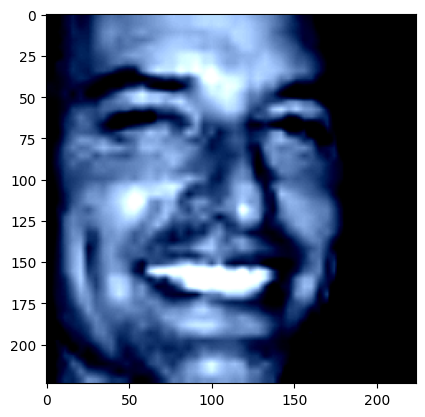

In [ ]:
# test
img, age, gender, eth = train_data[0]

# Assuming img contains images, select the first image from the batch
img = img.squeeze(dim=0).permute(1, 2, 0)

# Display the image using matplotlib
plt.imshow(img)
print(img.size())

In [ ]:
### Use pretrained model
import torchvision.models as models
model = models.vgg16(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 105MB/s]


In [ ]:
for param in model.parameters():
    param.requires_grad = False

model.avgpool = nn.Sequential(
    nn.Conv2d(512,512,kernel_size = 3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten()
)

In [ ]:
class AgeGenEthClassifier(nn.Module):
    def __init__(self):
        super(AgeGenEthClassifier,self).__init__()
        self.intermediate = nn.Sequential(
            nn.Linear(2048,512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128,64),
            nn.ReLU(),
        )
        self.age_classifier = nn.Sequential(
            nn.Linear(64,1),
            nn.Sigmoid()
        )
        self.gender_classifier = nn.Sequential(
            nn.Linear(64,1),
            nn.Sigmoid()
        )
        self.eth_classifier = nn.Sequential(
            nn.Linear(64,5),
            nn.Softmax()
        )

    def forward(self,x):
        x = self.intermediate(x)
        age = self.age_classifier(x)
        gender = self.gender_classifier(x)
        eth = self.eth_classifier(x)

        return age.to(device),gender.to(device),eth.to(device)

In [ ]:
model.classifier = AgeGenEthClassifier().to(device)
model = model.to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
loss_age_fn = nn.L1Loss().to(device)
loss_gen_fn = nn.BCELoss().to(device)
loss_et_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
import time
from tqdm.auto import tqdm

n_epochs = 3
val_gender_accuracies = []
val_age_maes = []
val_eth_accuracies = []
train_losses = []
val_losses = []
best_test_loss = 1000
start = time.time()
for epoch in tqdm(range(n_epochs)):
    epoch_train_loss = 0
    epoch_val_loss = 0
    val_age_mae = 0
    val_gender_acc = 0
    val_eth_acc = 0
    ctr = 0
    print(f"epochs: {epoch} ------------------------------------")

    # Training loop
    model.train()
    for ix, data in tqdm(enumerate(train_dataloader)):
        optimizer.zero_grad()
        im, age, gen, eth = data
        im = im.to(device)
        age = age.to(device)
        gen = gen.to(device)
        eth = eth.to(device)
        pred_age, pred_gen, pred_eth = model(im)
        age_loss = loss_age_fn(pred_age, age)
        gen_loss = loss_gen_fn(pred_gen, gen)
        eth_loss = loss_et_fn(pred_eth, eth)
        total_loss = age_loss + gen_loss + eth_loss
        total_loss.backward()
        optimizer.step()
        epoch_train_loss += total_loss.item()

    # Validation loop
    gender_acc = 0
    eth_acc = 0
    model.eval()
    with torch.no_grad():
        for ix, data in tqdm(enumerate(test_dataloader)):
            im, age, gen, eth = data
            im = im.to(device)
            age = age.to(device)
            gen = gen.to(device)
            eth = eth.to(device)
            pred_age, pred_gen, pred_eth = model(im)
            age_loss = loss_age_fn(pred_age, age)
            gen_loss = loss_gen_fn(pred_gen, gen)
            eth_loss = loss_et_fn(pred_eth, eth)
            total_loss = age_loss + gen_loss + eth_loss
            pred_gender = (pred_gen > 0.5)
            gender_acc += (pred_gender == gen).float().sum().item()
            pred_eth = (pred_eth > 0.5)
            eth_acc += (pred_eth == eth).float().sum().item()
            age_mae = torch.abs(age - pred_age).float().sum().item()
            val_age_mae += age_mae
            epoch_val_loss += total_loss.item()
            ctr += len(data[0])

    # Metrics calculation
    epoch_train_loss /= len(train_dataloader)
    epoch_val_loss /= len(test_dataloader)
    val_age_mae /= ctr
    val_gender_acc /= ctr
    val_eth_acc /= ctr

    # Update best test loss
    best_test_loss = min(best_test_loss, epoch_val_loss)

    # Print epoch info
    elapsed = time.time() - start
    print('{}/{} ({:.2f}s - {:.2f}s remaining)'.format(epoch+1, n_epochs, elapsed, (n_epochs-epoch-1)*(elapsed/(epoch+1))))
    info = f'''Epoch: {epoch+1} \tTrain Loss: {epoch_train_loss:.3f} \tTest Loss: {epoch_val_loss:.3f} \tBest Test Loss: {best_test_loss:.4f}\tAge MAE: {val_age_mae:.2f}\tGender Acc: {val_gender_acc:.2f}\tEth Acc: {val_eth_acc:.2f}'''
    print(info)

    # Append metrics to lists
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    val_gender_accuracies.append(val_gender_acc)
    val_age_maes.append(val_age_mae)
    val_eth_accuracies.append(val_eth_acc)


  0%|          | 0/3 [00:00<?, ?it/s]

epochs: 0 ------------------------------------


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


0it [00:00, ?it/s]

RuntimeError: The size of tensor a (5) must match the size of tensor b (64) at non-singleton dimension 1